In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # 1.6.0 버전
# !pip install torch==1.6.0
# !pip install torchvision==0.7.0

In [10]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

import piq

Thu Sep 23 01:20:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   50C    P2    79W / 260W |  43010MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 44%   

In [11]:
torch.__version__

'1.8.0+cu111'

## Setup imports

In [12]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import *
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-154-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [13]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Test

In [14]:
low_imgs      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/20/*/*/*.npy'))
high_imgs     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/X/*/*/*.npy'))

dcm_low_imgs  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/20/*/*/*.dcm'))
dcm_high_imgs = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(low_imgs, high_imgs, dcm_low_imgs, dcm_high_imgs)]

print("TEST [Total]  number = ", len(low_imgs))

TEST [Total]  number =  859


## Augmentation

In [15]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
#         CenterSpatialCropd(keys=["low", "high"], roi_size=(256, 256)),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [16]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/20/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163914/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_164102_00021.npy
/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/X/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163707/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_163912_00021.npy
image shape: torch.Size([512, 512])


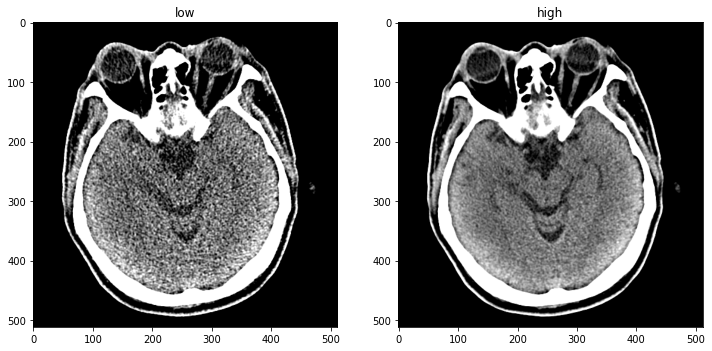

In [17]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [18]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  64


## Create Model, Loss, Optimizer

In [19]:
from Cyclegan_sunggu.model import *
from Cyclegan_sunggu.util import *
import itertools

device = 'cuda'

# 모델
netG_low_2_high = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)
netG_high_2_low = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)

netD_low  = CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')
netD_high = CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')

## 네트워크 불러오기

In [20]:
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Cycle_Gan_2D_sinogram/epoch_110_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG_low_2_high.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netG_high_2_low.load_state_dict(checkpoint['netG_high_2_low_state_dict'])
netD_low.load_state_dict(checkpoint['netD_low_state_dict'])
netD_high.load_state_dict(checkpoint['netD_high_state_dict'])
         
netG_low_2_high.to('cuda')  
netG_high_2_low.to('cuda')  
netD_low.to('cuda')  
netD_high.to('cuda')  


CycleGAN_Discriminator(
  (enc1): CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc2): CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc3): CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc4): CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (2)

###### 필요한 Weight만 Load

In [ ]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

## TEST

In [21]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [22]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [23]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [25]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/CycleGAN_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG_low_2_high.eval()
    netG_high_2_low.eval()
    netD_low.eval()
    netD_high.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG_low_2_high(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_low[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_high[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/859 [00:00<?, ?it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00001.dcm
3987.781 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00001.dcm
Test:   0%|          | 1/859 [00:00<09:27,  1.51it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00002.dcm
3998.4502 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001

Test:   2%|▏         | 17/859 [00:01<01:35,  8.81it/s]2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00018.dcm
2675.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00018.dcm
2673.7305 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00018.dcm
2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00019.dcm
2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00019.dcm
2737.164 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00019.dcm
Test:   2%|▏     

2690.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00035.dcm
2686.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00035.dcm
2682.9458 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00035.dcm
Test:   4%|▍         | 35/859 [00:03<01:07, 12.14it/s]2664.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00036.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00036.dcm
2669.9358 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00036.dcm
2695.0 0.0 float

Test:   6%|▌         | 51/859 [00:04<01:08, 11.88it/s]2562.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00052.dcm
2559.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00052.dcm
2538.6028 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00052.dcm
1759.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00053.dcm
1762.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00053.dcm
1531.6707 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00053.dcm
Test:   6%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00001.dcm
4010.6753 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
Test:   7%|▋         | 57/859 [00:05<01:06, 11.98it/s]3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00002.dcm
3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00002.dcm
3646.7896 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00

Test:   8%|▊         | 73/859 [00:06<01:06, 11.83it/s]2718.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00018.dcm
2709.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00018.dcm
2723.5886 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00018.dcm
2717.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00019.dcm
2703.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00019.dcm
2724.937 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_000

2490.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00035.dcm
2492.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00035.dcm
2516.3884 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00035.dcm
Test:  11%|█         | 91/859 [00:08<01:03, 12.05it/s]2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00036.dcm
2558.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00036.dcm
2590.9429 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00

Test:  12%|█▏        | 107/859 [00:09<01:01, 12.21it/s]2397.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00052.dcm
2408.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00052.dcm
2462.3574 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00052.dcm
2408.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00053.dcm
2388.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00053.dcm
2490.315 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00

2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00012.dcm
2638.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00012.dcm
2631.2659 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00012.dcm
Test:  15%|█▍        | 125/859 [00:10<01:00, 12.09it/s]2764.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00013.dcm
2767.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00013.dcm
2794.5334 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_0

Test:  16%|█▋        | 141/859 [00:12<00:59, 12.13it/s]2570.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00029.dcm
2566.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00029.dcm
2581.8433 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00029.dcm
2550.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00030.dcm
2551.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00030.dcm
2574.0076 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_0

2348.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00046.dcm
2339.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00046.dcm
2385.1597 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00046.dcm
Test:  19%|█▊        | 159/859 [00:13<00:57, 12.22it/s]2356.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00047.dcm
2357.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00047.dcm
2388.9302 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_0

Test:  20%|██        | 175/859 [00:15<00:56, 12.10it/s]3361.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00006.dcm
3358.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00006.dcm
3212.3635 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00006.dcm
2652.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00007.dcm
2660.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00007.dcm
2672.5962 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00007.dcm
Test:  21%|██  

2635.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00023.dcm
2635.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00023.dcm
2636.53 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00023.dcm
Test:  22%|██▏       | 193/859 [00:16<00:55, 11.95it/s]2767.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00024.dcm
2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00024.dcm
2804.4958 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00024.dcm
2608.0 0.0 float3

Test:  24%|██▍       | 209/859 [00:17<00:54, 11.86it/s]2535.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00040.dcm
2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00040.dcm
2561.9333 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00040.dcm
2513.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00041.dcm
2502.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00041.dcm
2516.1848 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00041.dcm
Test:  25%|██▍ 

425.99997 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00057.dcm
418.99997 11.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00057.dcm
166.17293 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00057.dcm
Test:  26%|██▋       | 227/859 [00:19<00:52, 11.94it/s]2978.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00001.dcm
2971.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00001.dcm
2981.2202 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_0

Test:  28%|██▊       | 243/859 [00:20<00:50, 12.08it/s]2713.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00017.dcm
2709.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00017.dcm
2710.489 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00017.dcm
2680.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00018.dcm
2680.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00018.dcm
2688.515 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_000

2588.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00034.dcm
2577.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00034.dcm
2574.3955 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00034.dcm
Test:  30%|███       | 261/859 [00:22<00:50, 11.81it/s]2587.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00035.dcm
2587.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00035.dcm
2598.0825 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_0

Test:  32%|███▏      | 277/859 [00:23<00:49, 11.69it/s]1028.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00051.dcm
1019.99994 11.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00051.dcm
1495.7773 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00051.dcm
1028.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00052.dcm
1016.99994 13.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00052.dcm
1647.4017 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_

2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00015.dcm
2723.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00015.dcm
2718.1226 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00015.dcm
Test:  34%|███▍      | 295/859 [00:25<00:47, 11.99it/s]2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00016.dcm
2741.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00016.dcm
2729.1514 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00016.dcm
2786.0 0.0 floa

Test:  36%|███▌      | 311/859 [00:26<00:45, 11.97it/s]2795.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00032.dcm
2785.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00032.dcm
2786.7253 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00032.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00033.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00033.dcm
2781.2266 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00033.dcm
Test:  36%|███▋

2548.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00049.dcm
2551.0 3.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00049.dcm
2390.2803 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00049.dcm
Test:  38%|███▊      | 329/859 [00:28<00:45, 11.70it/s]2575.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00050.dcm
2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00050.dcm
2390.6707 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00050.dcm
2585.0 0.

Test:  40%|████      | 345/859 [00:29<00:43, 11.93it/s]2892.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00010.dcm
2875.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00010.dcm
2886.39 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00010.dcm
2957.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00011.dcm
2953.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00011.dcm
3004.6035 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_000

2671.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00027.dcm
2670.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00027.dcm
2656.3508 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00027.dcm
Test:  42%|████▏     | 363/859 [00:30<00:42, 11.76it/s]2683.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00028.dcm
2678.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00028.dcm
2672.49 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_000

Test:  44%|████▍     | 379/859 [00:32<00:41, 11.60it/s]2495.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00044.dcm
2502.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00044.dcm
2491.65 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00044.dcm
2526.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00045.dcm
2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00045.dcm
2535.3682 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_000

2729.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00006.dcm
2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00006.dcm
2756.7869 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00006.dcm
Test:  46%|████▌     | 397/859 [00:33<00:38, 12.10it/s]2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00007.dcm
2721.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00007.dcm
2760.1199 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00007.dcm
2720.0 0.0 floa

Test:  48%|████▊     | 413/859 [00:35<00:38, 11.58it/s]2644.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00023.dcm
2639.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00023.dcm
2679.0215 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00023.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00024.dcm
2654.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00024.dcm
2652.0437 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00024.dcm
Test:  48%|████

2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00040.dcm
2657.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00040.dcm
2674.0117 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00040.dcm
Test:  50%|█████     | 431/859 [00:36<00:38, 11.20it/s]2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00041.dcm
2643.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00041.dcm
2659.2783 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00041.dcm
2611.0 0.0 floa

Test:  52%|█████▏    | 447/859 [00:38<00:35, 11.55it/s]1444.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00057.dcm
1450.0 8.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00057.dcm
1327.551 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00057.dcm
1078.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00058.dcm
1070.0 13.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00058.dcm
951.35 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00058.

2949.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00014.dcm
2932.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00014.dcm
2969.6714 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_00014.dcm
Test:  54%|█████▍    | 465/859 [00:39<00:34, 11.42it/s]3009.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00015.dcm
3008.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00015.dcm
3023.4268 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_0

Test:  56%|█████▌    | 481/859 [00:41<00:33, 11.21it/s]2672.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00031.dcm
2665.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00031.dcm
2657.4077 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00031.dcm
2670.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00032.dcm
2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00032.dcm
2648.3733 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_0

2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00048.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00048.dcm
2513.32 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00048.dcm
Test:  58%|█████▊    | 499/859 [00:42<00:29, 12.28it/s]2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00049.dcm
2463.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00049.dcm
2462.2432 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_000

Test:  60%|█████▉    | 515/859 [00:43<00:28, 12.14it/s]2708.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00002.dcm
2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00002.dcm
2715.71 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00002.dcm
2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00003.dcm
2665.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00003.dcm
2677.9497 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_000

2662.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00019.dcm
2646.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00019.dcm
2669.2583 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00019.dcm
Test:  62%|██████▏   | 533/859 [00:45<00:27, 12.06it/s]2648.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00020.dcm
2637.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00020.dcm
2649.691 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00

Test:  64%|██████▍   | 549/859 [00:46<00:28, 10.72it/s]2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00036.dcm
2645.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00036.dcm
2639.7756 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00036.dcm
2676.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00037.dcm
2661.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00037.dcm
2670.0664 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_0

2493.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00053.dcm
2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00053.dcm
2362.9014 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00053.dcm
Test:  66%|██████▌   | 567/859 [00:48<00:24, 11.68it/s]2511.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00054.dcm
2482.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00054.dcm
2349.7734 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_17

Test:  68%|██████▊   | 583/859 [00:49<00:22, 12.04it/s]2969.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00011.dcm
2970.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00011.dcm
3006.8242 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00011.dcm
2881.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00012.dcm
2876.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00012.dcm
2892.7124 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_0

2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00028.dcm
2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00028.dcm
2594.6777 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00028.dcm
Test:  70%|██████▉   | 601/859 [00:51<00:21, 11.94it/s]2557.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00029.dcm
2547.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00029.dcm
2543.1787 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_0

Test:  72%|███████▏  | 617/859 [00:52<00:19, 12.15it/s]2417.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00045.dcm
2428.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173731_00045.dcm
2404.4807 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_00045.dcm
2431.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00046.dcm
2438.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173731_00046.dcm
2368.7974 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_0

2746.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00009.dcm
2756.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00009.dcm
2755.3 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00009.dcm
Test:  74%|███████▍  | 635/859 [00:54<00:18, 11.88it/s]2733.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00010.dcm
2746.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00010.dcm
2739.767 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00010

Test:  76%|███████▌  | 651/859 [00:55<00:17, 11.70it/s]2600.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00026.dcm
2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00026.dcm
2601.5366 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00026.dcm
2589.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00027.dcm
2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00027.dcm
2592.5383 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_0

2586.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00043.dcm
2577.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00043.dcm
2585.002 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00043.dcm
Test:  78%|███████▊  | 669/859 [00:56<00:15, 12.00it/s]2522.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00044.dcm
2500.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00044.dcm
2534.2168 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00

Test:  80%|███████▉  | 685/859 [00:58<00:14, 11.64it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175633_00001.dcm
4087.0244 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175633_00002.dcm
4066.5032 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00002.dcm
Test:  80%|████

2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00018.dcm
2757.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00018.dcm
2773.7427 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00018.dcm
Test:  82%|████████▏ | 703/859 [00:59<00:12, 12.04it/s]2659.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00019.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00019.dcm
2660.2449 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00019.dcm
2710.0 0.0 floa

Test:  84%|████████▎ | 719/859 [01:01<00:11, 12.02it/s]3852.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00035.dcm
3851.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00035.dcm
3684.6396 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00035.dcm
3945.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00036.dcm
3942.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00036.dcm
3813.2583 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00036.dcm
Test:  84%|████

2511.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00052.dcm
2508.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00052.dcm
2349.99 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00052.dcm
Test:  86%|████████▌ | 737/859 [01:02<00:10, 11.91it/s]2511.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00053.dcm
2501.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00053.dcm
2314.5298 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00053.dcm
2482.0 0.0 float3

Test:  88%|████████▊ | 753/859 [01:04<00:09, 11.76it/s]2956.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00009.dcm
2947.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00009.dcm
2986.1602 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180811_00009.dcm
2984.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00010.dcm
2983.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00010.dcm
2991.173 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180811_00

2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00026.dcm
2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00026.dcm
2763.5957 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00026.dcm
Test:  90%|████████▉ | 771/859 [01:05<00:07, 11.94it/s]2752.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00027.dcm
2752.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00027.dcm
2775.1953 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_0

Test:  92%|█████████▏| 787/859 [01:06<00:05, 12.08it/s]2523.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00043.dcm
2517.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00043.dcm
2544.1116 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00043.dcm
2566.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00044.dcm
2566.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00044.dcm
2577.881 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_18

Test:  93%|█████████▎| 803/859 [01:08<00:04, 12.06it/s]2775.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00004.dcm
2784.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00004.dcm
2807.3857 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00004.dcm
2783.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00005.dcm
2778.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00005.dcm
2805.3135 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_0

2528.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00021.dcm
2527.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00021.dcm
2528.855 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00021.dcm
Test:  96%|█████████▌| 821/859 [01:09<00:03, 12.11it/s]2543.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00022.dcm
2525.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00022.dcm
2540.5647 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00

Test:  97%|█████████▋| 837/859 [01:11<00:01, 11.90it/s]2467.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00038.dcm
2461.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00038.dcm
2476.9082 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00038.dcm
2541.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00039.dcm
2549.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00039.dcm
2550.5266 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_0

1112.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00055.dcm
1110.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00055.dcm
973.15344 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00055.dcm
Test: 100%|█████████▉| 855/859 [01:12<00:00, 11.86it/s]1044.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00056.dcm
1055.0 13.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00056.dcm
864.36145 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/CycleGAN_epoch_110/low2high/20/pred_high_CHU_SOO_SEO_F

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [48]:
model_dir = "test_cyclegan_2d_epoch_110"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


In [50]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [51]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


449it [00:10, 42.23it/s]


### SSIM

In [ ]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [53]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


model SSIM index: 0.9958, loss: 0.0042
Input SSIM index: 0.9974, loss: 0.0026


### PSNR

In [54]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

model PSNR index: 52.9773
Input PSNR index: 56.4575


### 다시 PSNR 수정!

In [ ]:
plt.imshow(np_H.squeeze()[50:80, 250:280])

In [ ]:
t = (np_H[0] == -1000)
t[30:60, 250:280] = 1
k = (t)
plt.imshow(k)

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [56]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [75]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse     = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

449it [00:07, 61.59it/s]

Model MSE = 114.1646

Input MSE = 41.5295


## Difference Map

In [200]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [201]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

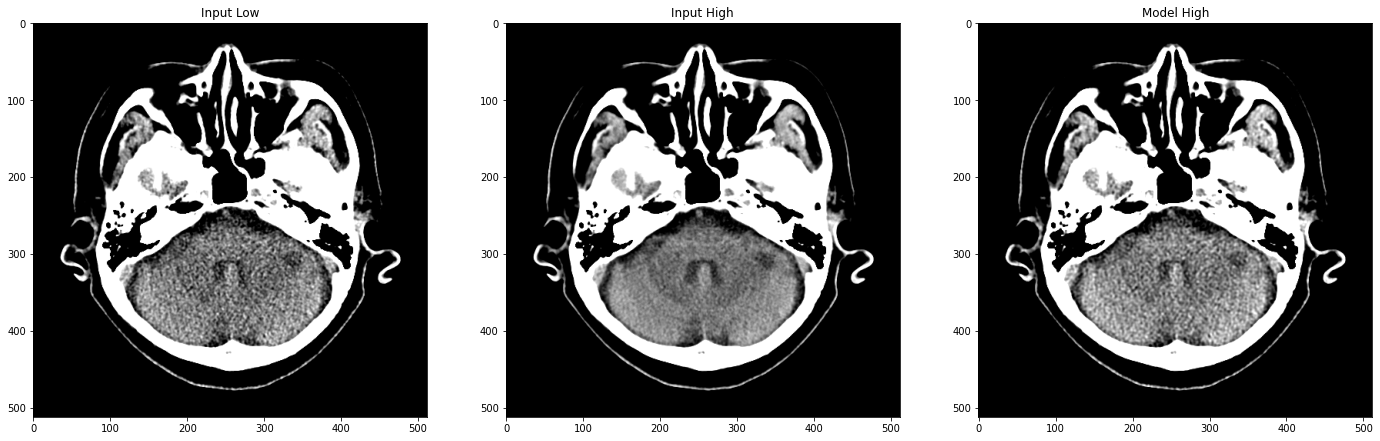

In [202]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

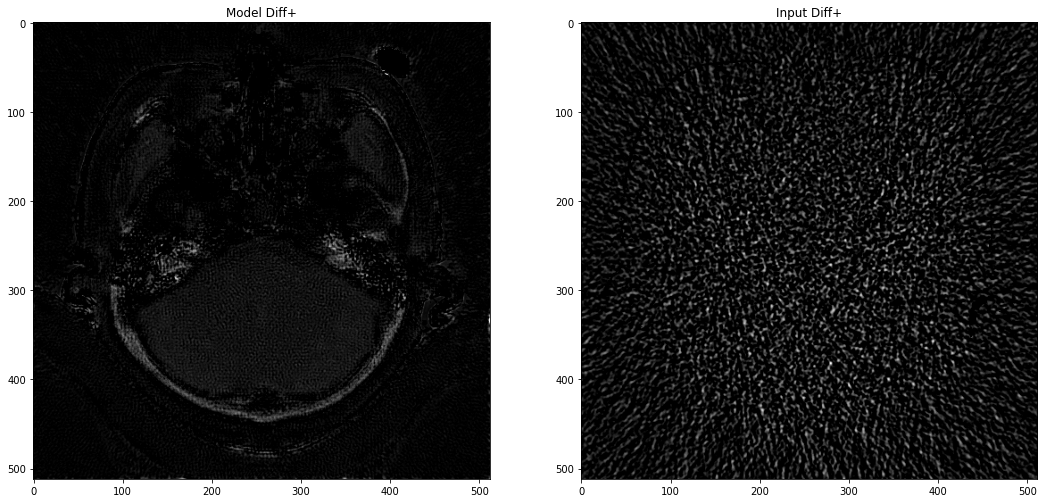

In [204]:
plt.figure(figsize=(18, 12))
plt.subplot(121)
t = (np_pred_H - np_input_L)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Model Diff+")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_diff_cycle.png', np.abs(np_pred_H - np_input_L)[0],   cmap="gray")

plt.subplot(122)
t = (np_gt_H - np_input_L)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Input Diff+")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_diff.png', np.abs(np_gt_H - np_input_L)[0],   cmap="gray")

plt.show()

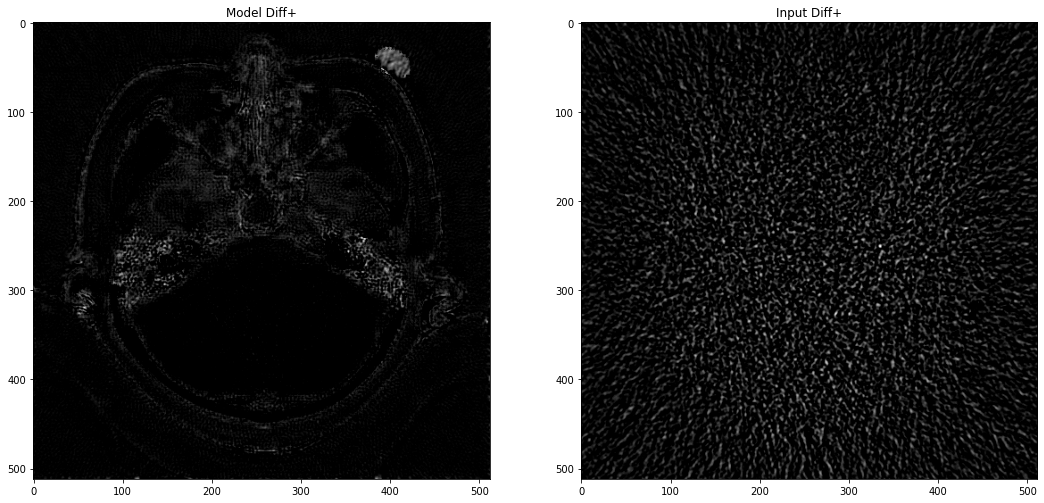

In [205]:
plt.figure(figsize=(18, 12))
plt.subplot(121)
t = (np_input_L - np_pred_H)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Model Diff+")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_diff_cycle.png', np.abs(np_pred_H - np_input_L)[0],   cmap="gray")

plt.subplot(122)
t = (np_input_L - np_gt_H)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Input Diff+")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_diff.png', np.abs(np_gt_H - np_input_L)[0],   cmap="gray")

plt.show()

In [192]:
np.abs(np_pred_H - np_input_L)[0].max(), np.abs(np_gt_H - np_pred_H)[0].min(), np.abs(np_gt_H - np_pred_H)[0].mean()

(86, 0, 5.9148406982421875)

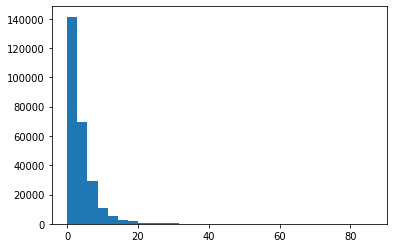

In [193]:
n, bins, patches = plt.hist(np.abs(np_pred_H - np_input_L)[0].flatten(), bins=30)

In [194]:
np.abs(np_gt_H - np_input_L)[0].max(), np.abs(np_gt_H - np_input_L)[0].min(), np.abs(np_gt_H - np_input_L)[0].mean()

(40, 0, 5.165294647216797)

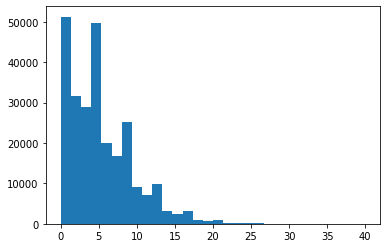

In [195]:
n, bins, patches = plt.hist(np.abs(np_gt_H - np_input_L)[0].flatten(), bins=30)

In [209]:
f.shape

(512, 512)

In [211]:
f[0][0]

(32386628+0j)

In [213]:
fshift[0][0]

(1016+0j)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('./data/messi5.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

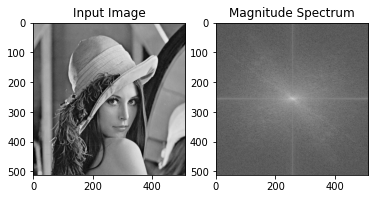

In [207]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('/workspace/sunggu/Public_dataset/lena.png', 0)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')

plt.subplot(122)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')

plt.show()

# Follow dataset TEST

## Set Train / Test

In [12]:
test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

dcm_test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Low Dose Neck*/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Neck Other*/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                  test_high_images, 
                                                                                  dcm_test_low_images, 
                                                                                  dcm_test_high_images)]

## Check transforms in DataLoader

/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-12-20 CT, Low Dose Neck With Enhance/000000004.npy
/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/51545804/2017-01-05 CT, Neck Other With Enhance/000000004.npy
image shape: torch.Size([512, 512])
tensor(0.3148) tensor(-1.) torch.float32 torch.Size([512, 512])


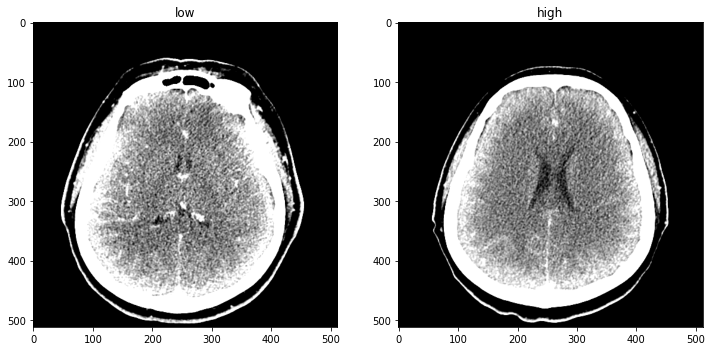

In [13]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[4]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [14]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=16, drop_last=False)

CPU 갯수 =  32


## TEST

In [15]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [16]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [17]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [19]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Follow_test_CycleGan_2d_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG_low_2_high.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG_low_2_high(input_low)

        # 저장하기
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/1020 [00:00<?, ?it/s]2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000000.dcm
2722.9172 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000000.dcm
Test:   0%|          | 1/1020 [00:02<43:59,  2.59s/it]2728.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000001.dcm
2714.7717 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000001.dcm
Test:   0%|          | 2/1020 [00:02<21:35,  1.27s/it]2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000002.dcm
2709.1338 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoc

Test:   2%|▏         | 24/1020 [00:10<06:36,  2.51it/s]2707.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000024.dcm
2692.5037 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000024.dcm
Test:   2%|▏         | 25/1020 [00:11<07:31,  2.20it/s]2740.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000025.dcm
2744.855 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000025.dcm
Test:   3%|▎         | 26/1020 [00:11<06:44,  2.46it/s]2760.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000026.dcm
2775.0396 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleG

Test:   5%|▍         | 48/1020 [00:17<04:29,  3.61it/s]2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000048.dcm
2520.097 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000048.dcm
Test:   5%|▍         | 49/1020 [00:17<04:15,  3.80it/s]2551.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000049.dcm
2510.1458 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000049.dcm
Test:   5%|▍         | 50/1020 [00:17<04:10,  3.87it/s]2585.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000050.dcm
2582.1648 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleG

Test:   7%|▋         | 72/1020 [00:23<03:51,  4.10it/s]2456.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000072.dcm
2270.7974 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000072.dcm
Test:   7%|▋         | 73/1020 [00:23<03:34,  4.41it/s]2417.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000073.dcm
2400.9038 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/pred_high_000000073.dcm
Test:   7%|▋         | 74/1020 [00:23<03:36,  4.37it/s]2347.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/51545804/gt_low_000000074.dcm
2230.3604 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dc

Test:  12%|█▏        | 119/1020 [00:36<04:22,  3.43it/s]2600.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000026.dcm
2580.261 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/pred_high_000000026.dcm
Test:  12%|█▏        | 120/1020 [00:36<04:14,  3.54it/s]2796.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000027.dcm
2791.447 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/pred_high_000000027.dcm
Test:  12%|█▏        | 121/1020 [00:37<03:53,  3.85it/s]2847.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000028.dcm
2820.4504 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  14%|█▍        | 143/1020 [00:43<03:36,  4.04it/s]2270.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000050.dcm
2450.5188 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/pred_high_000000050.dcm
Test:  14%|█▍        | 144/1020 [00:43<03:33,  4.10it/s]2158.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000051.dcm
2226.736 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/pred_high_000000051.dcm
Test:  14%|█▍        | 145/1020 [00:43<03:37,  4.02it/s]1956.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52079564/gt_low_000000052.dcm
1947.0737 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_t

Test:  19%|█▊        | 189/1020 [00:55<03:38,  3.80it/s]2626.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000019.dcm
2624.581 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000019.dcm
Test:  19%|█▊        | 190/1020 [00:56<03:53,  3.55it/s]2641.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000020.dcm
2622.363 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000020.dcm
Test:  19%|█▊        | 191/1020 [00:56<04:02,  3.42it/s]2654.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000021.dcm
2625.9116 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  23%|██▎       | 235/1020 [01:09<02:45,  4.74it/s]2239.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000065.dcm
2438.8694 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000065.dcm
Test:  23%|██▎       | 236/1020 [01:09<02:46,  4.72it/s]2138.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000066.dcm
2318.6282 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000066.dcm
Test:  23%|██▎       | 237/1020 [01:09<02:43,  4.78it/s]2306.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000067.dcm
2407.5254 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  28%|██▊       | 281/1020 [01:22<03:16,  3.76it/s]2203.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000111.dcm
1769.6935 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000111.dcm
Test:  28%|██▊       | 282/1020 [01:22<03:11,  3.85it/s]2264.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000112.dcm
1915.729 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/pred_high_000000112.dcm
Test:  28%|██▊       | 283/1020 [01:22<03:09,  3.88it/s]2107.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52100901/gt_low_000000113.dcm
1958.212 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  30%|██▉       | 305/1020 [01:29<03:49,  3.12it/s]2702.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000019.dcm
2636.4092 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000019.dcm
Test:  30%|███       | 306/1020 [01:29<03:50,  3.10it/s]2691.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000020.dcm
2617.8262 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000020.dcm
Test:  30%|███       | 307/1020 [01:30<03:47,  3.13it/s]2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000021.dcm
2682.1028 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  35%|███▍      | 352/1020 [01:42<02:38,  4.23it/s]2450.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000066.dcm
2591.559 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000066.dcm
Test:  35%|███▍      | 353/1020 [01:43<02:29,  4.46it/s]2526.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000067.dcm
2839.112 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000067.dcm
Test:  35%|███▍      | 354/1020 [01:43<02:28,  4.47it/s]2483.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000068.dcm
2827.6897 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  37%|███▋      | 376/1020 [01:48<02:37,  4.08it/s]2433.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000090.dcm
2501.4294 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000090.dcm
Test:  37%|███▋      | 377/1020 [01:48<02:31,  4.26it/s]2413.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000091.dcm
2472.6914 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/pred_high_000000091.dcm
Test:  37%|███▋      | 378/1020 [01:49<02:31,  4.24it/s]2376.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52347894/gt_low_000000092.dcm
2471.965 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  39%|███▉      | 400/1020 [01:55<03:04,  3.36it/s]2693.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000003.dcm
2684.744 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000003.dcm
Test:  39%|███▉      | 401/1020 [01:55<02:58,  3.47it/s]2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000004.dcm
2701.0503 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000004.dcm
Test:  39%|███▉      | 402/1020 [01:55<02:58,  3.46it/s]2700.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000005.dcm
2700.5452 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  42%|████▏     | 424/1020 [02:02<02:27,  4.05it/s]2605.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000027.dcm
2573.0237 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000027.dcm
Test:  42%|████▏     | 425/1020 [02:03<02:22,  4.17it/s]2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000028.dcm
2534.0325 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000028.dcm
Test:  42%|████▏     | 426/1020 [02:03<02:16,  4.34it/s]2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000029.dcm
2574.815 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  44%|████▍     | 448/1020 [02:08<02:06,  4.52it/s]2311.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000051.dcm
2623.6377 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000051.dcm
Test:  44%|████▍     | 449/1020 [02:08<02:22,  4.00it/s]2309.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000052.dcm
2629.995 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/pred_high_000000052.dcm
Test:  44%|████▍     | 450/1020 [02:09<02:20,  4.06it/s]2312.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52351259/gt_low_000000053.dcm
2727.1758 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  48%|████▊     | 494/1020 [02:20<02:39,  3.29it/s]2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000006.dcm
2634.5544 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000006.dcm
Test:  49%|████▊     | 495/1020 [02:21<02:40,  3.26it/s]2733.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000007.dcm
2643.331 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000007.dcm
Test:  49%|████▊     | 496/1020 [02:21<02:40,  3.27it/s]2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000008.dcm
2642.3684 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  53%|█████▎    | 540/1020 [02:35<01:59,  4.00it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000052.dcm
3920.3318 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000052.dcm
Test:  53%|█████▎    | 541/1020 [02:35<02:04,  3.86it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000053.dcm
3892.489 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000053.dcm
Test:  53%|█████▎    | 542/1020 [02:35<02:06,  3.79it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000054.dcm
3782.724 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  55%|█████▌    | 564/1020 [02:41<01:59,  3.83it/s]2453.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000076.dcm
2403.4692 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000076.dcm
Test:  55%|█████▌    | 565/1020 [02:41<01:55,  3.95it/s]2483.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000077.dcm
2465.6382 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000077.dcm
Test:  55%|█████▌    | 566/1020 [02:42<01:53,  4.00it/s]2429.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000078.dcm
2418.335 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  60%|█████▉    | 610/1020 [02:54<02:40,  2.56it/s]2295.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000122.dcm
2498.9565 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000122.dcm
Test:  60%|█████▉    | 611/1020 [02:55<02:43,  2.51it/s]2247.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000123.dcm
2771.726 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/pred_high_000000123.dcm
Test:  60%|██████    | 612/1020 [02:55<02:32,  2.68it/s]2280.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52465336/gt_low_000000124.dcm
2665.688 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  62%|██████▏   | 634/1020 [03:02<02:01,  3.17it/s]2674.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000016.dcm
2597.1934 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000016.dcm
Test:  62%|██████▏   | 635/1020 [03:03<02:03,  3.12it/s]2611.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000017.dcm
2552.086 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000017.dcm
Test:  62%|██████▏   | 636/1020 [03:03<02:02,  3.14it/s]2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000018.dcm
2551.5757 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

Test:  67%|██████▋   | 680/1020 [03:15<01:21,  4.18it/s]2736.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000062.dcm
2622.281 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000062.dcm
Test:  67%|██████▋   | 681/1020 [03:15<01:18,  4.30it/s]2711.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000063.dcm
2586.2654 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000063.dcm
Test:  67%|██████▋   | 682/1020 [03:16<01:16,  4.43it/s]2755.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000064.dcm
2660.452 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  69%|██████▉   | 704/1020 [03:22<01:41,  3.11it/s]2272.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000086.dcm
2566.7695 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000086.dcm
Test:  69%|██████▉   | 705/1020 [03:22<01:40,  3.12it/s]2267.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000087.dcm
2459.6182 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/pred_high_000000087.dcm
Test:  69%|██████▉   | 706/1020 [03:22<01:36,  3.26it/s]2332.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52561195/gt_low_000000088.dcm
2454.8008 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  74%|███████▎  | 750/1020 [03:34<01:19,  3.41it/s]2611.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000004.dcm
2599.1553 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000004.dcm
Test:  74%|███████▎  | 751/1020 [03:34<01:21,  3.28it/s]2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000005.dcm
2585.8345 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000005.dcm
Test:  74%|███████▎  | 752/1020 [03:34<01:25,  3.14it/s]2605.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000006.dcm
2593.1628 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  76%|███████▌  | 774/1020 [03:40<01:03,  3.85it/s]2717.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000028.dcm
2733.4465 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000028.dcm
Test:  76%|███████▌  | 775/1020 [03:40<01:00,  4.07it/s]3998.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000029.dcm
4015.5984 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000029.dcm
Test:  76%|███████▌  | 776/1020 [03:41<01:28,  2.76it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000030.dcm
4069.2156 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  80%|████████  | 820/1020 [03:53<00:55,  3.59it/s]2073.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000074.dcm
2018.5483 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000074.dcm
Test:  80%|████████  | 821/1020 [03:54<00:55,  3.61it/s]2141.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000075.dcm
2068.9749 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/pred_high_000000075.dcm
Test:  81%|████████  | 822/1020 [03:54<00:54,  3.65it/s]1877.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52584996/gt_low_000000076.dcm
1838.2292 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  85%|████████▌ | 867/1020 [04:06<00:40,  3.78it/s]3573.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000038.dcm
3507.67 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000038.dcm
Test:  85%|████████▌ | 868/1020 [04:07<00:38,  3.98it/s]3789.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000039.dcm
3770.4224 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000039.dcm
Test:  85%|████████▌ | 869/1020 [04:07<00:40,  3.76it/s]3840.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000040.dcm
3758.7097 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cycl

Test:  87%|████████▋ | 891/1020 [04:12<00:27,  4.74it/s]2467.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000062.dcm
2466.856 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000062.dcm
Test:  87%|████████▋ | 892/1020 [04:12<00:27,  4.71it/s]2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000063.dcm
2917.6685 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000063.dcm
Test:  88%|████████▊ | 893/1020 [04:12<00:28,  4.47it/s]2672.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000064.dcm
2865.9846 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cyc

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000085.dcm
Test:  90%|████████▉ | 915/1020 [04:19<00:34,  3.05it/s]2196.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000086.dcm
2135.755 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000086.dcm
Test:  90%|████████▉ | 916/1020 [04:19<00:41,  2.53it/s]2178.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/gt_low_000000087.dcm
2159.6055 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/52957121/pred_high_000000087.dcm
Test:  90%|████████▉ | 917/1020 [04:20<00:44,  2.29it/s]2342.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epo

Test:  92%|█████████▏| 938/1020 [04:27<00:23,  3.44it/s]2556.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000013.dcm
2557.3442 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000013.dcm
Test:  92%|█████████▏| 939/1020 [04:27<00:24,  3.30it/s]2537.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000014.dcm
2535.5974 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000014.dcm
Test:  92%|█████████▏| 940/1020 [04:27<00:25,  3.18it/s]2547.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000015.dcm
2536.1245 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  94%|█████████▍| 962/1020 [04:33<00:17,  3.34it/s]3380.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000037.dcm
3256.9824 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000037.dcm
Test:  94%|█████████▍| 963/1020 [04:34<00:15,  3.59it/s]3836.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000038.dcm
3740.0703 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000038.dcm
Test:  95%|█████████▍| 964/1020 [04:34<00:15,  3.60it/s]4047.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000039.dcm
3936.1057 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Cy

Test:  99%|█████████▉| 1008/1020 [04:46<00:04,  2.81it/s]2153.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000083.dcm
2028.105 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000083.dcm
Test:  99%|█████████▉| 1009/1020 [04:46<00:04,  2.55it/s]2164.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000084.dcm
2010.4213 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/pred_high_000000084.dcm
Test:  99%|█████████▉| 1010/1020 [04:47<00:03,  2.65it/s]2091.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_CycleGan_2d_epoch_110/low2high/53782539/gt_low_000000085.dcm
1938.9923 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follo